# Task Description

In [60]:
# The task would be to test a long-only stock-based carry/value strategy.

# Carry strategy in stocks would be to long high dividend yield stocks and short the reverse (in this case no need to do short).
# Whole value strategy you should be familiar with.

# Carry trade in rate hike periods work pretty well (for fx especially). We are interested in whether the same hold for value. 
# The underlying assets would be S&P 500 stocks.

# Please take into account that some companies do stock repurchase instead of cash dividend.
# You could try to find adjusted dividend yield data. Time horizon is up to you, but keep in mind potential survivorship bias.
# It might be interesting to check the strategy performance during different periods. 
# Remember to make the backtest a way that they could be implemented (not longing 100 stocks at the same time). 
# Have a nice night and good luck with your presentation on Monday.

# Setup

## Load Packages

In [61]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scipy as sp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # to calculate the MSE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from statsmodels.graphics.tsaplots import plot_acf # To produce ACF plots
from statsmodels.graphics.tsaplots import plot_pacf # To produce PACF plots
from statsmodels.tsa.seasonal import seasonal_decompose # To decompose Seasons
from statsmodels.tsa.stattools import adfuller, kpss # Tests for Stationarity
from statsmodels.tsa.ar_model import AutoReg # To produce AR models
from statsmodels.stats.anova import anova_lm # To use ANOVA (compare nested models)
from statsmodels.tsa.arima.model import ARIMA # To build ARMA & ARIMA Models
import statsmodels.stats.diagnostic as dg # To get Breusch-Godfrey Test
from statsmodels.stats.stattools import durbin_watson



from datetime import datetime # to transform variables into datetime objects
import math # simple math functions
from math import sqrt # square root function
import statistics # descriptive statistics library
import scipy.stats as stats # descriptive statistics library from scipy
import matplotlib.dates as mdates # date formatting
from matplotlib.collections import PolyCollection, LineCollection # better plot options

## Useful functions for Matrix calculations

In [62]:
def f(x, y): 
    return x + y                             
vecsum = np.vectorize(f)     # Use pd.DataFrame(vecsum(A,B)) to get df of elementwise sum

In [63]:
def g(x, y): 
    return x - y                             
vecdif = np.vectorize(g)     # Use pd.DataFrame(vecdif(A,B)) to get df of elementwise differences

In [64]:
def h(x, y): 
    return x * y                             
vecmult = np.vectorize(h)    # Use pd.DataFrame(vecmult(A,B)) to get df of elementwise multiplication

In [65]:
def i(x, y): 
    return x / y                             
vecdiv = np.vectorize(i)    # Use pd.DataFrame(vecdiv(A,B)) to get df of elementwise division

## Plotstyle

In [66]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

## LoadData

In [67]:
# Loading Data

data_px = pd.read_excel("02_Data_clean/SPX_px_cleanest.xlsx", parse_dates=["Date"])
data_px_yly = pd.read_excel("02_Data_clean/SPX_px_clean_yearly.xlsx", parse_dates=["Date"])
data_bv = pd.read_excel("02_Data_clean/SPX_value_clean.xlsx", parse_dates=["Date"])

bv_resample_fail = pd.read_excel("02_Data_clean/SPX_btm_resample_fail_clean.xlsx")

# Check
print(type(data_bv))
print(data_bv.dtypes)

<class 'pandas.core.frame.DataFrame'>
Date                  datetime64[ns]
AEE UN Equity                float64
ITT UN Equity                float64
UN UN Equity                 float64
APD UN Equity                float64
                           ...      
NTAP UQ Equity               float64
CTXS UQ Equity               float64
9990253D UN Equity           float64
0948669D UN Equity           float64
CMCSK UQ Equity              float64
Length: 501, dtype: object


In [133]:
fed_fund_rate = pd.read_excel("02_Data_clean/FED_Fund_rate_Upper_bound.xlsx")
fed_fund_rate = fed_fund_rate.set_index(['Date'])

## Data Cleaning

In [68]:
# Resample monthly returns
data_px.set_index("Date", inplace=True) # set datetimeindex
data_bv.set_index("Date", inplace=True) # set datetimeindex
data_px_yly.set_index("Date", inplace=True) # set datetimeindex


In [69]:
# Create monthly returns
mtl_ret = data_px.pct_change(fill_method = None).resample("M").agg(lambda x: ((1+x).prod()-1)) # pct_change creates ordinary returns

In [70]:
mtl_ret = mtl_ret.loc["1999-12-31":"2022-06-30", :]
mtl_ret

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2000-01-31,-0.013359,-0.061693,-0.154995,-0.111732,-0.104447,-0.077739,-0.063958,-7.569918e-02,-0.046896,-0.020385,...,-0.230947,-0.372249,0.036145,-0.050173,-0.406042,0.194131,0.096543,-3.773585e-02,-0.055556,-0.097650
2000-02-29,-0.106383,-0.258959,-0.050270,-0.123689,-0.051963,0.022989,-0.177875,-1.724138e-01,-0.139288,-0.144578,...,0.339338,0.208027,0.017442,0.602026,-0.025421,0.945179,0.483783,-1.110223e-16,-0.193277,-0.016438
2000-03-31,0.071429,0.336014,0.101576,0.088516,0.121803,-0.059925,0.290239,9.548889e-02,0.300791,-0.038412,...,-0.244394,0.117922,-0.085714,0.196929,-0.023191,-0.142210,-0.337915,2.320261e-01,0.013889,-0.033426
2000-04-30,0.185859,0.016098,-0.053249,0.092307,-0.003257,0.071713,-0.030676,-2.220446e-16,-0.079109,0.002663,...,-0.612760,-0.273755,-0.046875,-0.115472,-0.403559,-0.106495,-0.078301,1.405836e-01,-0.006849,-0.076371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,-0.018483,-0.022958,0.000000,-0.134171,0.000000,0.215517,0.023062,-7.009346e-02,0.074803,0.033037,...,-0.016665,0.024699,0.000000,0.095364,0.000000,-0.072132,-0.027949,1.671839e-02,0.000000,0.000000
2022-03-31,0.055213,-0.121441,0.000000,0.025709,0.000000,0.087766,-0.052476,1.940554e-01,0.206083,-0.021002,...,-0.037661,-0.075821,0.000000,0.000000,0.000000,0.069254,-0.014815,7.955888e-02,0.000000,0.000000
2022-04-30,0.023353,-0.097081,0.000000,-0.050657,0.000000,-0.090872,-0.097114,-5.739613e-02,-0.074656,0.050057,...,0.064201,-0.115718,0.000000,0.000000,0.000000,-0.145174,-0.009695,-1.223094e-01,0.000000,0.000000


### Create Book to Market Dataframe

In [71]:
# Divide BVPS yearly by SP yearly to get Book to market signal yearly
data_btm = pd.DataFrame(vecdiv(data_bv, data_px_yly))

In [72]:
# Set Datetimeindex again
data_btm.set_index(data_px_yly.index, inplace=True) # set datetimeindex

### Resample BTM for monthly rebalance

In [180]:
data_btm.to_excel("data_btm.xlsx")


In [177]:
data_btm_mt = data_btm.resample("M").ffill()

In [75]:
bv_resample_fail.set_index("Date", inplace=True)


In [76]:
# data_btm_mt = data_btm_mt.append(bv_resample_fail) # Months until June 2022 added bc resample is a bitch

In [77]:
data_btm_mt = pd.concat(
    [data_btm_mt, bv_resample_fail],
    axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

In [172]:
data_btm_mt

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.687548,2.255177,NaN,0.396526,NaN,0.593069,0.173405,0.328235,0.312175,0.066077,...,0.072443,0.041892,0.192825,0.120038,0.093066,0.036970,0.030054,NaN,0.821638,0.269750
2000-01-31,0.687548,2.255177,NaN,0.396526,NaN,0.593069,0.173405,0.328235,0.312175,0.066077,...,0.072443,0.041892,0.192825,0.120038,0.093066,0.036970,0.030054,NaN,0.821638,0.269750
2000-02-29,0.687548,2.255177,NaN,0.396526,NaN,0.593069,0.173405,0.328235,0.312175,0.066077,...,0.072443,0.041892,0.192825,0.120038,0.093066,0.036970,0.030054,NaN,0.821638,0.269750
2000-03-31,0.687548,2.255177,NaN,0.396526,NaN,0.593069,0.173405,0.328235,0.312175,0.066077,...,0.072443,0.041892,0.192825,0.120038,0.093066,0.036970,0.030054,NaN,0.821638,0.269750
2000-04-30,0.687548,2.255177,NaN,0.396526,NaN,0.593069,0.173405,0.328235,0.312175,0.066077,...,0.072443,0.041892,0.192825,0.120038,0.093066,0.036970,0.030054,NaN,0.821638,0.269750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.422882,0.254748,NaN,0.194736,NaN,0.705674,0.380389,0.148787,0.614084,0.089811,...,0.161332,0.087870,NaN,NaN,NaN,0.041408,0.046336,NaN,NaN,0.365469
2022-03-31,0.422882,0.254748,NaN,0.194736,NaN,0.705674,0.380389,0.148787,0.614084,0.089811,...,0.161332,0.087870,NaN,NaN,NaN,0.041408,0.046336,NaN,NaN,0.365469
2022-04-30,0.422882,0.254748,NaN,0.194736,NaN,0.705674,0.380389,0.148787,0.614084,0.089811,...,0.161332,0.087870,NaN,NaN,NaN,0.041408,0.046336,NaN,NaN,0.365469


# FIXING

In [181]:
btm_new = pd.read_excel("02_Data_clean/BTM_fixed.xlsx", parse_dates=["Date"])

In [173]:
btm_new

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.687548,2.255177,NaN,0.396526,NaN,0.593069,0.173405,0.328235,0.312175,0.066077,...,0.072443,0.041892,0.192825,0.120038,0.093066,0.036970,0.030054,NaN,0.821638,0.269750
2000-12-29,0.503035,2.144498,NaN,0.360660,NaN,0.363339,0.279691,0.344678,0.367843,0.061525,...,0.109996,0.077946,0.321816,0.125596,0.620553,0.038123,0.191617,NaN,1.747709,0.370010
2001-12-31,0.573714,1.850806,NaN,0.351160,NaN,0.373367,0.281501,0.312739,0.355083,0.096959,...,0.141373,0.137141,0.236743,0.145012,0.279635,0.117128,0.193733,NaN,1.027075,0.425333
2002-12-31,0.599757,1.230955,NaN,0.432227,NaN,0.399176,0.342336,0.347664,0.445066,0.108978,...,0.290730,0.261550,0.307107,0.279335,0.755586,0.289830,0.372598,NaN,1.034823,1.851919
2003-12-31,0.581046,1.627601,NaN,0.403004,NaN,0.287442,0.384540,0.212970,0.392958,0.113714,...,0.227858,0.061788,0.268775,0.184734,0.632461,0.192918,0.254445,NaN,0.859031,0.594079
2004-12-31,0.592603,1.813283,NaN,0.384744,NaN,0.276338,0.373477,0.223296,0.408785,0.158895,...,0.199878,0.062788,0.245959,0.257508,0.628285,0.136246,0.277909,NaN,0.792525,0.570202
2005-12-30,0.606741,1.730565,NaN,0.414191,NaN,0.256728,0.497176,0.217566,0.494487,0.171268,...,0.237882,0.086611,0.270167,0.315938,0.485216,0.189467,0.300080,NaN,0.920187,-0.051072
2006-12-29,0.593030,1.661677,NaN,0.392752,NaN,0.535309,0.481218,0.173175,0.433117,0.151283,...,0.287625,0.254573,0.261678,0.251617,0.467053,0.137963,0.380439,NaN,0.846942,0.472658
2007-12-31,0.597949,1.985222,NaN,0.263554,NaN,0.417018,0.432618,0.196195,0.395121,0.152853,...,0.340090,0.275367,0.351747,0.272506,0.415503,0.158766,0.324173,NaN,0.953148,0.641595


# Strategy

## Calculate Desired Weights

In [79]:
# The approach is as follows: 
# 1. Take Book to market value as BVPS(t-6mt) / SP(t-6mt)
# 2. for each month calculate the 10 stocks considered for the long strategy
# 3. calculate the PF return
# 4. take into account the transaction costs

In [80]:
np.shape(data_btm_mt)

(271, 500)

In [81]:
# Create empty df for weights
cols = (data_btm_mt.columns[0:])
rows = (data_btm_mt.iloc[:,0])

des_weight = pd.DataFrame(index = rows, columns = (cols))
des_weight.set_index(data_btm_mt.index, inplace=True) # set datetimeindex
des_weight

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
data_btm_mt.index = data_btm_mt.index.astype('datetime64[ns]')

In [83]:
data_btm_mt.index.dtype

dtype('<M8[ns]')

In [84]:
# Assign weights based on 10 largest BTM value
for i in data_btm_mt.index:
    x = data_btm_mt.loc[i,:].nlargest(10)
    for j in data_btm_mt.columns:
        if j in x.index:
            des_weight.loc[i,j] = 0.1
        else:
            des_weight.loc[i,j] = 0

In [85]:
des_weight.head(26)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-02-29,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-04-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-06-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-07-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-08-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Weighted Returns on 30. June

In [86]:
# Cut for analysis dataframe
mtl_ret = mtl_ret.loc["2000-06-30":"2022-06-30", :]
des_weight = des_weight.loc["2000-06-30":"2022-06-30", :]

In [87]:
weighted_ret = pd.DataFrame(vecmult(des_weight, mtl_ret))

In [88]:
weighted_ret.set_index(mtl_ret.index, inplace=True) # set datetimeindex
weighted_ret

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,-0.0,-0.007605,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
2000-07-31,0.0,-0.000205,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
2000-08-31,0.0,0.007422,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,0.0,-0.000383,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
2000-10-31,-0.0,-0.002698,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,-0.0,-0.000000,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
2022-03-31,0.0,-0.000000,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2022-04-30,0.0,-0.000000,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0


## PF returns weighted per year

In [89]:
ones500x1 = np.ones(len(weighted_ret.columns))
pd.DataFrame(ones500x1)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
495,1.0
496,1.0
497,1.0
498,1.0


In [90]:
pf_ret_unadj = np.matmul(weighted_ret,ones500x1)
pf_ret_unadj = pd.DataFrame(pf_ret_unadj)
pf_ret_unadj.columns =["PF_returns_unadjusted"]
pf_ret_unadj.loc["2000-06-30"] = 0.0 #bc we do not make returns in first period
pf_ret_unadj

,PF_returns_unadjusted
Date,
2000-06-30,0.000000
2000-07-31,0.000014
2000-08-31,0.093643
2000-09-30,0.044508
2000-10-31,-0.045510
...,...
2022-02-28,0.012900
2022-03-31,0.052130
2022-04-30,-0.055551


## Actual weights

In [91]:
# 1+return -> for stock returns and for the weighted PF returns -> used for actual weights calculation
mtl_ret_gross = mtl_ret.transform(lambda x: x + 1)
pf_ret_unadj_gross = pf_ret_unadj.transform(lambda x: x + 1)
mtl_ret_gross


,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,0.916808,0.923949,0.799997,0.894738,1.008188,1.000000,0.983071,0.888525,0.928182,1.052692,...,1.375000,0.908229,0.976190,1.234579,1.102991,1.380493,0.406165,0.930622,1.027027,1.290835
2000-07-31,1.077778,0.997955,1.058144,1.070992,0.952284,0.890034,0.924970,1.005538,0.949890,1.091404,...,0.917615,1.040627,0.910566,0.869796,0.759041,1.055901,0.798683,0.879177,0.888158,0.766974
2000-08-31,1.075601,1.074221,1.079668,1.136365,1.054371,1.000000,0.914893,1.104584,1.077579,0.893319,...,1.294118,0.942941,1.133929,1.275022,1.039683,1.186029,1.516527,1.116959,1.070370,1.221332
2000-09-30,1.070288,0.996166,0.982186,0.959999,0.969666,0.942085,1.126454,0.897010,0.982000,0.984375,...,0.837321,1.210191,0.893700,0.935154,1.022893,1.263484,0.874656,0.958115,0.968858,1.079077
2000-10-31,0.926866,0.973019,1.047932,1.010417,0.992701,0.893443,1.095484,0.974074,0.942083,1.069163,...,1.131427,1.050877,0.907489,0.758394,0.843283,0.965653,1.043617,1.000000,0.989286,1.024425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.981517,0.977042,1.000000,0.865829,1.000000,1.215517,1.023062,0.929907,1.074803,1.033037,...,0.983335,1.024699,1.000000,1.095364,1.000000,0.927868,0.972051,1.016718,1.000000,1.000000
2022-03-31,1.055213,0.878559,1.000000,1.025709,1.000000,1.087766,0.947524,1.194055,1.206083,0.978998,...,0.962339,0.924179,1.000000,1.000000,1.000000,1.069254,0.985185,1.079559,1.000000,1.000000
2022-04-30,1.023353,0.902919,1.000000,0.949343,1.000000,0.909128,0.902886,0.942604,0.925344,1.050057,...,1.064201,0.884282,1.000000,1.000000,1.000000,0.854826,0.990305,0.877691,1.000000,1.000000


In [92]:
# Create (23x500) matrix to match midyear return matrix for scaling factor to calculate adjusted weights
ones_matrix = np.ones((len(pf_ret_unadj_gross),500))
pf_ret_unadj_gross_matrix = pd.DataFrame(vecmult(pf_ret_unadj_gross, ones_matrix))
pf_ret_unadj_gross_matrix

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,...,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014,1.000014
2,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,...,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643,1.093643
3,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,...,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508,1.044508
4,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,...,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490,0.954490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,...,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900,1.012900
261,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,...,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130,1.052130
262,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,...,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449,0.944449
263,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,...,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205,1.039205


In [93]:
# Calculate weight scaling factor by deviding the returns of the assets, per year by the weighted pf return per year
weight_scaleFactor = pd.DataFrame(vecdiv(mtl_ret_gross,pf_ret_unadj_gross_matrix), columns = mtl_ret_gross.columns, index = mtl_ret_gross.index)

In [94]:
des_weight

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-07-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-08-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-10-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
# Shift by -1 to create w(t-1) but last row becomes N/A
des_weight_lag1 = des_weight.shift(1)

In [96]:
# Calculate actual weights before rebalancing
actual_weight = pd.DataFrame(vecmult(des_weight_lag1, weight_scaleFactor), columns = weight_scaleFactor.columns, index = weight_scaleFactor.index)
actual_weight

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-31,0.0,0.099794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-08-31,0.0,0.098224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,0.0,0.095372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-10-31,0.0,0.101941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-31,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-30,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Turnover

In [97]:
des_weight

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-07-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-08-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-10-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
actual_weight.head(25)

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-31,0.0,0.099794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-08-31,0.0,0.098224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,0.0,0.095372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-10-31,0.0,0.101941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-11-30,0.0,0.100508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,0.0,0.113000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-31,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-28,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
turnover = pd.DataFrame(abs(vecdif(des_weight, actual_weight)), index = weight_scaleFactor.index)
turnover.loc["2000-06-30",:] = des_weight.loc["2000-06-30",:] # Adjust for buying the whole portfolio at the 30.06.2000
turnover

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-30,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-07-31,0.0,0.000206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-08-31,0.0,0.001776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,0.0,0.004628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-10-31,0.0,0.001941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-31,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-30,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
turnover_mtl = np.matmul(turnover,ones500x1)
turnover_mtl = pd.DataFrame(turnover_mtl, columns = ["Yearly Turnover of PF"])
turnover_mtl.head(40)

,Yearly Turnover of PF
Date,
2000-06-30,1.000000
2000-07-31,0.094161
2000-08-31,0.105097
2000-09-30,0.085019
2000-10-31,0.062044
2000-11-30,0.064452
2000-12-31,1.532839
2001-01-31,0.182813
2001-02-28,0.158853


# Adjust Portfolio Return for Transaction cost and turnover

In [101]:
# Calculate transaction costs yearly by multiplying turnover and transaction costs
c = np.ones(len(turnover_mtl)) * 0.002 # 0.2% from Michael Milliker for S&P500 stocks -> transaction cost corresponding to turnover in %
c = pd.DataFrame(c)
tc_mtl = pd.DataFrame(vecmult(turnover_mtl,c), index=turnover_mtl.index, columns= ["TC_mtl"])
tc_mtl

,TC_mtl
Date,
2000-06-30,0.002000
2000-07-31,0.000188
2000-08-31,0.000210
2000-09-30,0.000170
2000-10-31,0.000124
...,...
2022-02-28,0.000054
2022-03-31,0.000198
2022-04-30,0.000148


In [125]:
pf_ret_adj = pd.DataFrame(vecdif(pf_ret_unadj, tc_mtl), index = tc_mtl.index, columns = ["PF_ret_adj"])
pf_ret_adj.describe()

,PF_ret_adj
count,265.000000
mean,0.013668
std,0.092663
min,-0.273992
25%,-0.024828
50%,0.009392
75%,0.049600
max,0.382367


# Plot Results

In [129]:
pf_ret_adj_gross = pf_ret_adj.transform(lambda x: x + 1)
pf_ret_adj_gross_cum = pf_ret_adj_gross.cumprod() # We don't start at one bc of initial costs for buying pf
pf_ret_unadj_gross_cum = pf_ret_unadj_gross.cumprod() # We don't start at one bc of initial costs for buying pf
pf_ret_adj_gross_cum.columns = ["pf_ret_adj_cum"]
pf_ret_adj.describe()

,PF_ret_adj
count,265.000000
mean,0.013668
std,0.092663
min,-0.273992
25%,-0.024828
50%,0.009392
75%,0.049600
max,0.382367


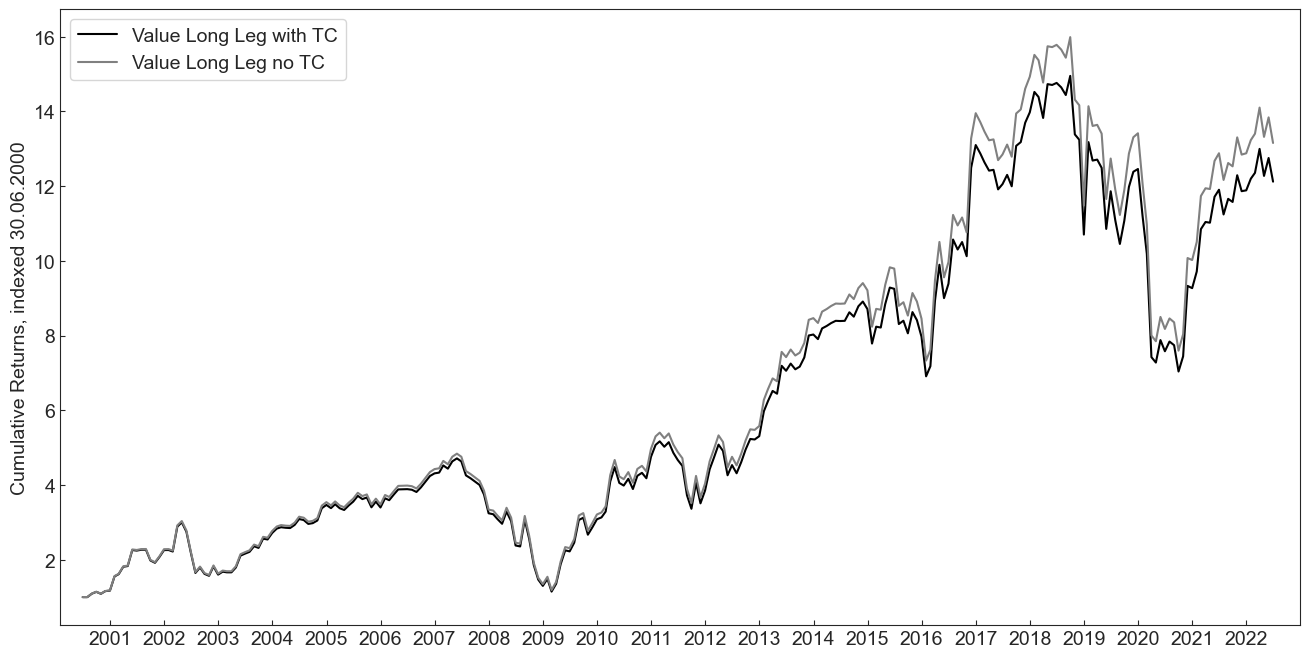

In [168]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Value Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Value Long Leg no TC", color="grey")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
ax.set_xlim([pd.to_datetime('2000-01-30'), pd.to_datetime('2022-12-30')])
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.savefig("03_Figures/Value_Performance_monthly_rebalance")

In [140]:
fed_fund_rate_cut = fed_fund_rate.loc["2000-06-30" : "2022-06-30",:]

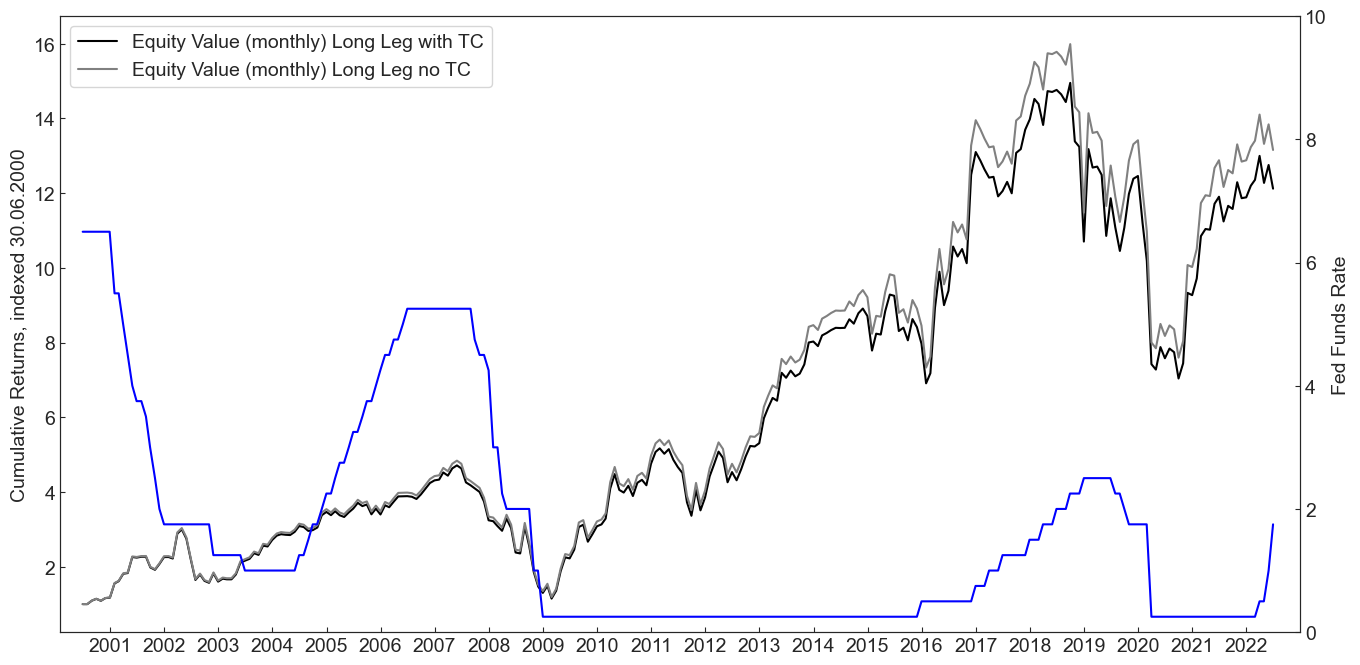

In [146]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Equity Value (monthly) Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Equity Value (monthly) Long Leg no TC", color="grey")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
ax2 = ax.twinx()
ax2.plot(fed_fund_rate_cut.index, fed_fund_rate_cut.iloc[:,1], label="Fed Fund Rate", color = "blue")
ax2.set_ylabel('Fed Funds Rate')
plt.ylim((0.00,10))
ax.set_xlim([pd.to_datetime('2000-01-30'), pd.to_datetime('2022-12-30')])
ax.xaxis.set_major_locator(mdates.YearLocator())

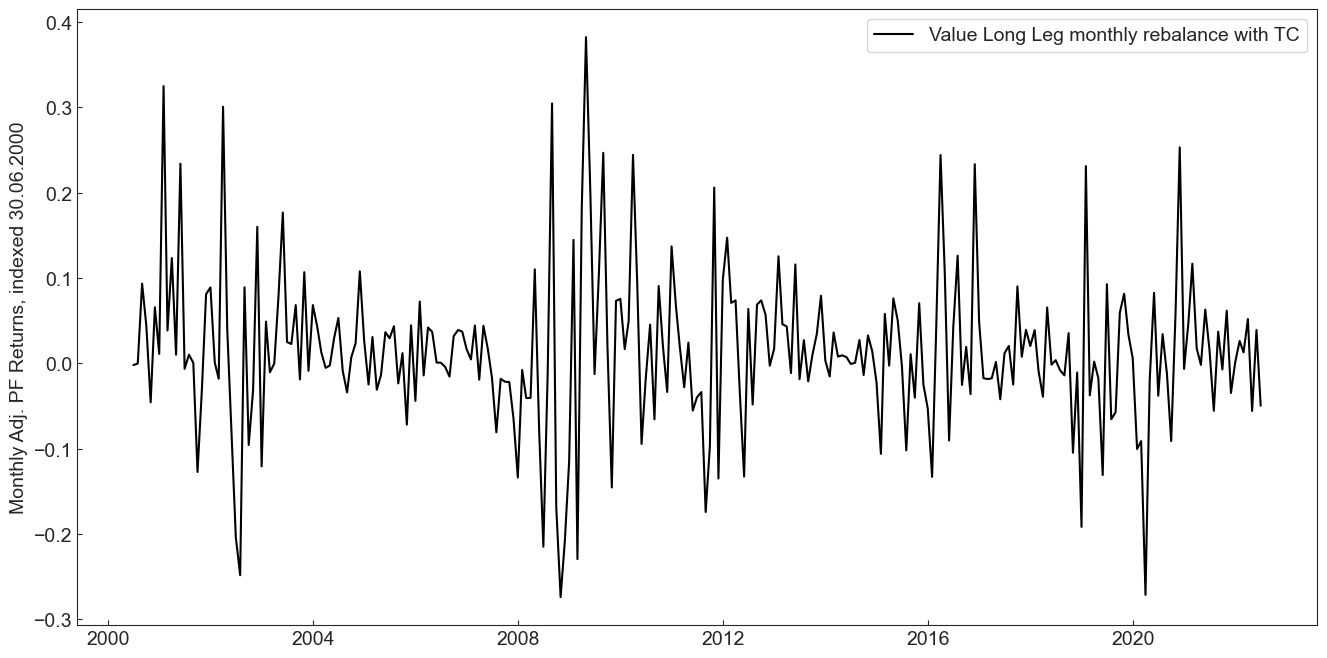

In [106]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj.index,pf_ret_adj, label="Value Long Leg monthly rebalance with TC", color="black")
ax.legend(loc="best")
ax.set_ylabel('Monthly Adj. PF Returns, indexed 30.06.2000')
plt.savefig("03_Figures/Value_monthly_returns")

In [123]:
pf_ret_adj.describe()

,PF_ret_adj
count,265.000000
mean,0.013668
std,0.092663
min,-0.273992
25%,-0.024828
50%,0.009392
75%,0.049600
max,0.382367


In [108]:
x = [i for i in pf_ret_adj.iloc[:,0] if i > 0.05]
len(x)

66

In [109]:
x = [i for i in pf_ret_adj.iloc[:,0] if i < -0.05]
len(x)

41

In [110]:

# mtl_ret_describe = mtl_ret.describe()
# mtl_ret_describe.to_excel("mlt_ret_describe.xlsx")

# pf_ret_adj.to_excel("pf_ret_adj.xlsx")

# des_weight.columns = [mtl_ret.columns]
# des_weight.to_excel("des_weights.xlsx")
# mtl_ret.to_excel("mtl_ret.xlsx")

dtypes = data_px.dtypes
dtypes.to_excel("dtypes.xlsx")

# Performance Statistics

In [111]:
pf_ret_adj.describe()

,PF_ret_adj
count,265.000000
mean,0.013668
std,0.092663
min,-0.273992
25%,-0.024828
50%,0.009392
75%,0.049600
max,0.382367


In [154]:
pf_ret_adj

,PF_ret_adj
Date,
2000-06-30,-0.002000
2000-07-31,-0.000174
2000-08-31,0.093432
2000-09-30,0.044338
2000-10-31,-0.045634
...,...
2022-02-28,0.012846
2022-03-31,0.051932
2022-04-30,-0.055699


In [155]:
x = 1
for i in pf_ret_adj.iloc[:,0]:
    #print(i)
    x = (1+i)*x
PF_return_annual = (x**(4/(88)))-1
PF_return_annual

0.12008561264680528

In [165]:
pf_ret_adj.describe().iloc[2]

PF_ret_adj    0.092663
Name: std, dtype: float64

In [167]:
print(pf_ret_adj.describe())
print(f'annual std: {pf_ret_adj.describe().iloc[2]*(12)**0.5}')
print(f'SR: {(0.12008561264680528 - 0.0171)/(pf_ret_adj.describe().iloc[2]*(12)**0.5)}')
print(f'Skew: {sp.stats.skew(pf_ret_adj)}')
print(f'Kurt: {sp.stats.kurtosis(pf_ret_adj)}')

       PF_ret_adj
count  265.000000
mean     0.013668
std      0.092663
min     -0.273992
25%     -0.024828
50%      0.009392
75%      0.049600
max      0.382367
annual std: PF_ret_adj    0.320995
Name: std, dtype: float64
SR: PF_ret_adj    0.320833
Name: std, dtype: float64
Skew: [0.37395051]
Kurt: [2.52843126]


In [112]:
pf_ret_adj.mean()

PF_ret_adj    0.013668
dtype: float64

# Comparison with Benchmark & FED Fund Rate

In [113]:
data_spx = pd.read_excel("02_Data_clean/SPX_Index_clean.xlsx", parse_dates=["Date"])
data_fund = pd.read_excel("02_Data_clean/FED_Fund_rate_Upper_bound.xlsx", parse_dates=["Date"])
data_spx.set_index("Date", inplace=True) # set datetimeindex

In [114]:
spx_gross = data_spx.transform(lambda x: x + 1)
spx_gross_cum = spx_gross.cumprod() 

In [115]:
spx_gross_cum.head(20)

,SPX Index
Date,
2000-06-30,1.023934
2000-07-31,1.007201
2000-08-31,1.068337
2000-09-29,1.011199
2000-10-31,1.006195
2000-11-30,0.925630
2000-12-29,0.929382
2001-01-31,0.961573
2001-02-28,0.872828


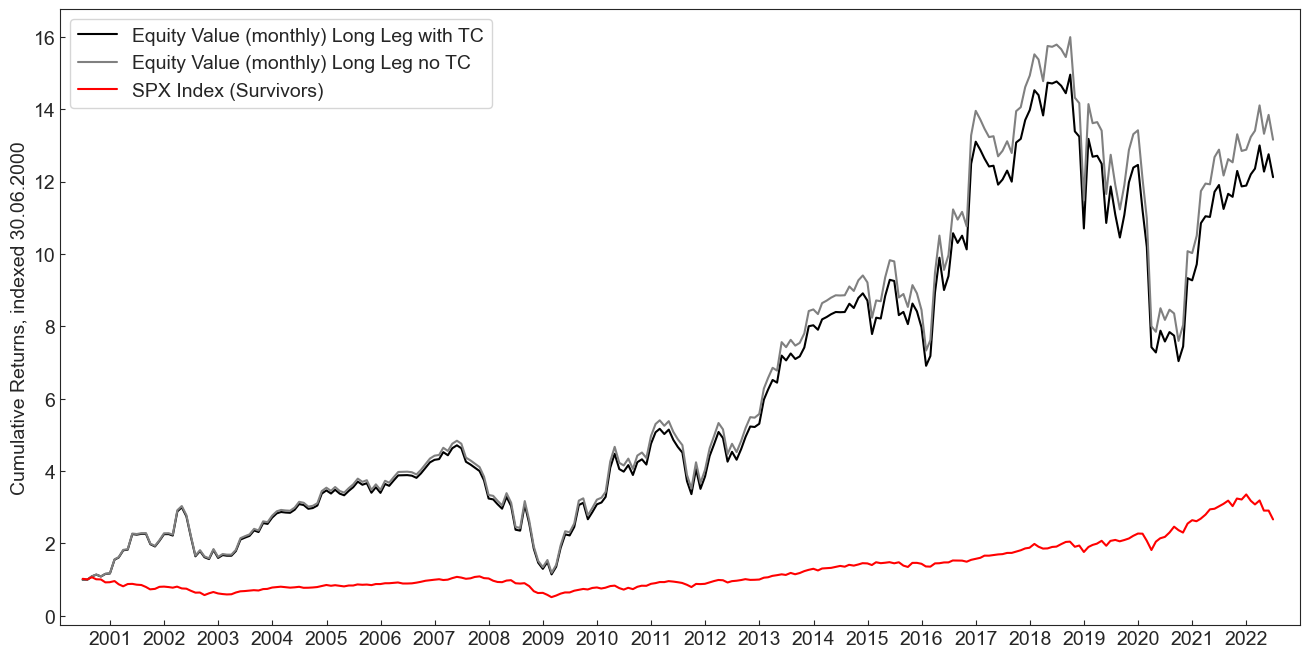

In [147]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Equity Value (monthly) Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Equity Value (monthly) Long Leg no TC", color="grey")
ax.plot(spx_gross_cum.index,spx_gross_cum, label="SPX Index (Survivors)", color="red")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
ax.set_xlim([pd.to_datetime('2000-01-30'), pd.to_datetime('2022-12-30')])
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.savefig("03_Figures/Value_Performance_mtl_rbl_index_comparison")